# Notebook for `nowcast` results

Before running this notebook, download the pretrained models as described in the `README`


In [35]:
import os
os.environ["HDF5_USE_FILE_LOCKING"]='FALSE'
import sys
sys.path.append('/content/drive/MyDrive/neurips-2020-sevir/src')
import h5py
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import matplotlib.patches as patches
import pandas as pd
#from display.display import get_cmap

In [36]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [37]:
import sys
module_path = '/content/drive/MyDrive/neurips-2020-sevir/src'
sys.path.insert(0,module_path)

In [38]:
from display.display import get_cmap

In [39]:
if not os.path.exists('/content/export'):
  os.makedirs('/content/export')

## Load pretrained models

In [40]:
# Load pretrained nowcasting models
# mse_file  = '/content/drive/MyDrive/neurips-2020-sevir/models/nowcast/mse_model.h5'
# mse_model = tf.keras.models.load_model(mse_file,compile=False,custom_objects={"tf": tf})

# style_file = '/content/drive/MyDrive/neurips-2020-sevir/models/nowcast/style_model.h5'
# style_model = tf.keras.models.load_model(style_file,compile=False,custom_objects={"tf": tf})

# mse_style_file = '/content/drive/MyDrive/neurips-2020-sevir/models/nowcast/mse_and_style.h5'
# mse_style_model = tf.keras.models.load_model(mse_style_file,compile=False,custom_objects={"tf": tf})

gan_file = '/content/drive/MyDrive/neurips-2020-sevir/models/nowcast/gan_generator.h5'
gan_model = tf.keras.models.load_model(gan_file,compile=False,custom_objects={"tf": tf})

## Load sample test data

To download sample test data, go to https://www.dropbox.com/s/27pqogywg75as5f/nowcast_testing.h5?dl=0
 and save file to `data/sample/nowcast_testing.h5`


In [42]:
# Load a part of the test dataset
from readers.nowcast_reader import read_data
x_test,y_test = read_data('/content/drive/MyDrive/neurips-2020-sevir/data/interim/nowcast_testing.h5',end=50)

## Plot samples for test set

In [43]:
## 
# Functions for plotting results
##

norm = {'scale':47.54,'shift':33.44}
hmf_colors = np.array( [
    [82,82,82], 
    [252,141,89],
    [255,255,191],
    [145,191,219]
])/255

# Model that implements persistence forecast that just repeasts last frame of input
class persistence:
    def predict(self,x_test):
        return np.tile(x_test[:,:,:,-1:],[1,1,1,12])

def plot_hit_miss_fa(ax,y_true,y_pred,thres):
    mask = np.zeros_like(y_true)
    mask[np.logical_and(y_true>=thres,y_pred>=thres)]=4
    mask[np.logical_and(y_true>=thres,y_pred<thres)]=3
    mask[np.logical_and(y_true<thres,y_pred>=thres)]=2
    mask[np.logical_and(y_true<thres,y_pred<thres)]=1
    cmap=ListedColormap(hmf_colors)
    ax.imshow(mask,cmap=cmap)


def visualize_result(models,x_test,y_test,idx,ax,labels, save_path='/content/image.png'):
    fs=12
    cmap_dict = lambda s: {'cmap':get_cmap(s,encoded=True)[0],
                           'norm':get_cmap(s,encoded=True)[1],
                           'vmin':get_cmap(s,encoded=True)[2],
                           'vmax':get_cmap(s,encoded=True)[3]}
    for i in range(0,13):
        xt = x_test[idx,:,:,i]*norm['scale']+norm['shift']
        
        ax[(i-1)][0].imshow(xt,**cmap_dict('vil'))
    ax[0][0].set_title('Inputs',fontsize=fs)
    
    pers = persistence().predict(x_test[idx:idx+1])
    pers = pers*norm['scale']+norm['shift']
    x_test = x_test[idx:idx+1]
    y_test = y_test[idx:idx+1]*norm['scale']+norm['shift']
    y_preds=[]
    for i,m in enumerate(models):
        yp = m.predict(x_test)
        if isinstance(yp,(list,)):
            yp=yp[0]
        y_preds.append(yp*norm['scale']+norm['shift'])
    
    for i in range(0,12):
        ax[i][1].imshow(y_test[0,:,:,i],**cmap_dict('vil'))
    ax[0][1].set_title('Outputs',fontsize=fs)


        
    for j in range(len(ax)):
        for i in range(len(ax[j])):
            ax[j][i].xaxis.set_ticks([])
            ax[j][i].yaxis.set_ticks([])


    ax[0][0].set_ylabel('-60 Minutes', fontsize=8)
    ax[1][0].set_ylabel('-55 Minutes', fontsize=8)
    ax[2][0].set_ylabel('-50 Minutes', fontsize=8)
    ax[3][0].set_ylabel('-45 Minutes', fontsize=8)
    ax[4][0].set_ylabel('-40 Minutes', fontsize=8)
    ax[5][0].set_ylabel('-35 Minutes', fontsize=8)
    ax[6][0].set_ylabel('-30 Minutes', fontsize=8)
    ax[7][0].set_ylabel('-25 Minutes', fontsize=8)
    ax[8][0].set_ylabel('-20 Minutes', fontsize=8)
    ax[9][0].set_ylabel('-15 Minutes', fontsize=8)
    ax[10][0].set_ylabel('-10 Minutes', fontsize=8)
    ax[11][0].set_ylabel('-5 Minutes', fontsize=8)
    ax[12][0].set_ylabel('0 Minutes', fontsize=8)

    ax[0][1].set_ylabel('+5 Minutes', fontsize=8)
    ax[1][1].set_ylabel('+10 Minutes', fontsize=8)
    ax[2][1].set_ylabel('+15 Minutes', fontsize=8)
    ax[3][1].set_ylabel('+20 Minutes', fontsize=8)
    ax[4][1].set_ylabel('+25 Minutes', fontsize=8)
    ax[5][1].set_ylabel('+30 Minutes', fontsize=8)
    ax[6][1].set_ylabel('+35 Minutes', fontsize=8)
    ax[7][1].set_ylabel('+40 Minutes', fontsize=8)
    ax[8][1].set_ylabel('+45 Minutes', fontsize=8)
    ax[9][1].set_ylabel('+50 Minutes', fontsize=8)
    ax[10][1].set_ylabel('+55 Minutes', fontsize=8)
    ax[11][1].set_ylabel('+60 Minutes', fontsize=8)
    
    
    plt.subplots_adjust(hspace=0.05, wspace=0.05)

    plt.savefig(save_path)
    

### Plot a few test cases

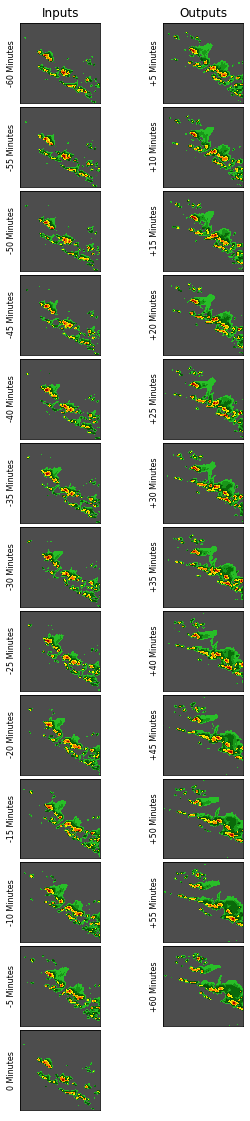

In [44]:
idx=33
fig,ax = plt.subplots(13,2,figsize=(5,20))
fig.delaxes(ax[12][1])
visualize_result([gan_model],x_test,y_test,idx,ax,labels=['cGAN+MAE'])

In [45]:
!pip install fastapi nest-asyncio pyngrok uvicorn
!pip install PyJWT python-decouple
!pip install pydantic[email]

In [46]:
from fastapi import FastAPI, Body, Depends, Request
from fastapi.responses import Response
from fastapi.middleware.cors import CORSMiddleware
import nest_asyncio
from pyngrok import ngrok
import uvicorn
from datetime import datetime
import os
import random
import traceback
import base64

In [47]:
!echo -e "secret = 9c22c93620e98a0dd73bb704adfcacae\nalgorithm = HS256" >> .env

In [48]:
# This file is responsible for signing, encoding, decoding and returning JWTS.

import time
import jwt
from decouple import AutoConfig
config = AutoConfig(search_path='/content')

JWT_SECRET = config("secret")
JWT_ALGORITHM = config("algorithm")

# Fuction returns the generated tokens
def token_response(token : str):
    return {
        "access_token" : token
    }

def signJWT(userID : str):
    payload = {
        "userID" : userID,
        "expiry" : time.time() + 600
    }
    token = jwt.encode(payload, JWT_SECRET, algorithm=JWT_ALGORITHM)
    return token_response(token)

def decodeJWT(token : str):
    try:
        decode_token = jwt.decode(token, JWT_SECRET, algorithm=JWT_ALGORITHM)
        return decode_token if decode_token['expires'] >= time.time() else None
    except:
        return {}

In [49]:
# The function of this file is to check whether the request is authorized or not [verification of the protected route]

from concurrent.futures.process import _ThreadWakeup
from fastapi import Request, HTTPException
from fastapi.security import HTTPBearer, HTTPAuthorizationCredentials

class jwtBearer(HTTPBearer):
    def __init__(self, auto_Error : bool = True):
        super(jwtBearer, self).__init__(auto_error=auto_Error)

    async def __call__(self, request : Request):
        credentials : HTTPAuthorizationCredentials = await super(jwtBearer, self).__call__(request)
        if credentials:
            if not credentials.scheme == "Bearer":
                raise HTTPException(status_code = 403, details="Invalid or Expired Token!")
            return credentials.credentials
        else:
            raise HTTPException(status_code = 403, details="Invalid or Expired Token!")

# function to chcek if token is valid or not
    def verify_jwt(self, jwtoken : str):
        isTokenValid : bool = False # a false flag
        payload = decodeJWT(jwtoken)
        if payload:
            isTokenValid = True
        return isTokenValid

In [50]:
from pydantic import BaseModel, Field, EmailStr
from email.policy import default

class PostSchema(BaseModel):
    id : int = Field(default=None)
    title : str = Field(default=None)
    content : str = Field(default=None)

    class Config:
        schema_extra = {
            "post_demo" : {
                "title" : "some title about animals",
                "content" : "some content for animals"
            }
        }

class UserSchema(BaseModel):
    fullname : str = Field(default=None)
    email : EmailStr = Field(default=None)
    password : str = Field(default=None)

    class Config:
        the_schema = {
            "user_demo" : {
                "name" : "Bek",
                "email" : "help@bek.com",
                "password" : "12345"
            }
        }

class UserLoginSchema(BaseModel):
    email : EmailStr = Field(default=None)
    password : str = Field(default=None)

    class Config:
        the_schema = {
            "user_login_demo" : {
                "email" : "help@bek.com",
                "password" : "12345"
            }
        }

In [51]:
users = []

In [52]:
image_path = ""

_locs = ["houston", "adrian", "appleton", "omaha", "charlottesville", "dallas", "austin", "atlanta", "malibu", "chicago", "arlington", "fairfax", "cody", "douglas", "wichita"]

def pullImages():
  all_files = os.listdir(image_path)
  integer = random.randint(0, len(all_files))
  with open(os.path.join(image_path, all_files[integer]), "rb") as file:
    image_bytes: bytes = base64.b64encode(file.read())
  return image_bytes

Public URL: http://10d6-35-227-50-192.ngrok.io


INFO:     Started server process [492]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://127.0.0.1:8000 (Press CTRL+C to quit)


email='vac@bek.com' password='vac'
INFO:     54.86.50.139:0 - "POST /user/login HTTP/1.1" 200 OK
email='help@bek.com' password='12345'
INFO:     54.86.50.139:0 - "POST /user/login HTTP/1.1" 200 OK
INFO:     54.86.50.139:0 - "POST /user/signup HTTP/1.1" 200 OK
email='help@bek.com' password='12345'
INFO:     54.86.50.139:0 - "POST /user/login HTTP/1.1" 200 OK
email='vac@bek.com' password='vac'
INFO:     54.86.50.139:0 - "POST /user/login HTTP/1.1" 200 OK
INFO:     52.114.128.147:0 - "GET / HTTP/1.1" 404 Not Found
email='vac@bek.com' password='vac'
INFO:     2601:197:601:9520:2833:4289:4986:5c2f:0 - "POST /user/login HTTP/1.1" 200 OK
email='vac@bek.com' password='vac'
INFO:     173.76.198.16:0 - "POST /user/login HTTP/1.1" 200 OK
INFO:     2601:197:601:9520:2833:4289:4986:5c2f:0 - "GET /event?idx_id=37 HTTP/1.1" 200 OK
INFO:     173.76.198.16:0 - "GET /event?idx_id=32 HTTP/1.1" 200 OK
email='vac@bek.com' password='vac'
INFO:     20.119.208.242:0 - "POST /user/login HTTP/1.1" 200 OK
INFO: 

INFO:     Shutting down
INFO:     Waiting for application shutdown.
INFO:     Application shutdown complete.
INFO:     Finished server process [492]


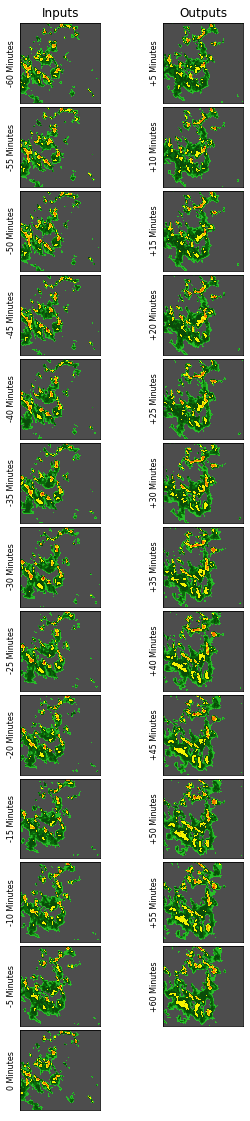

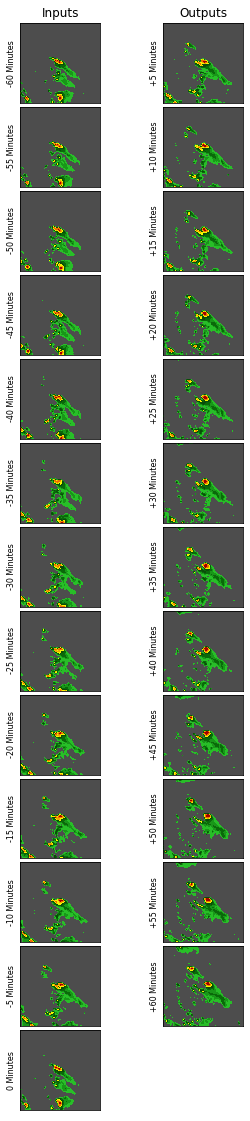

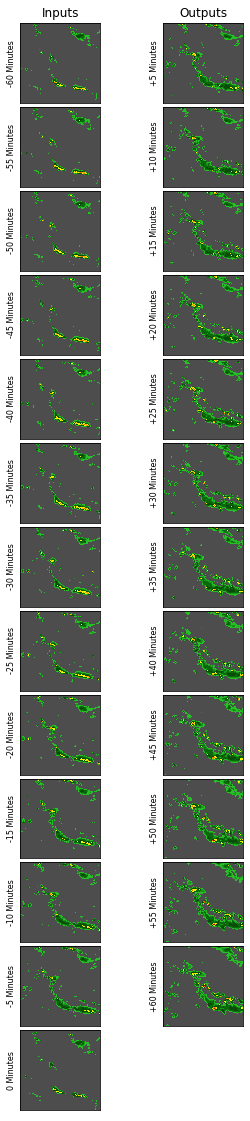

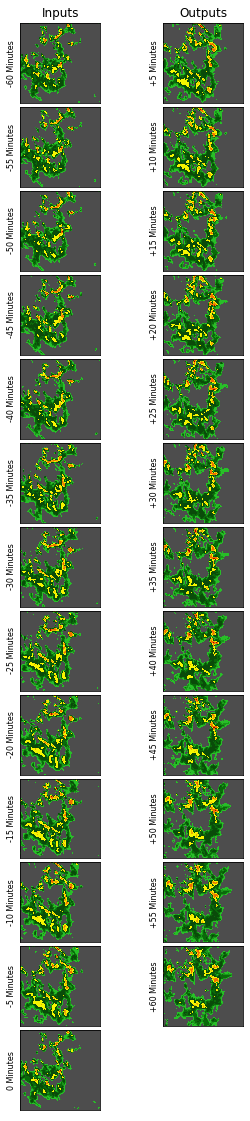

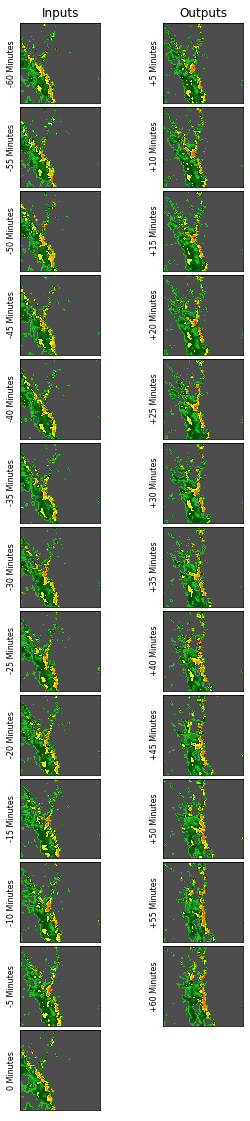

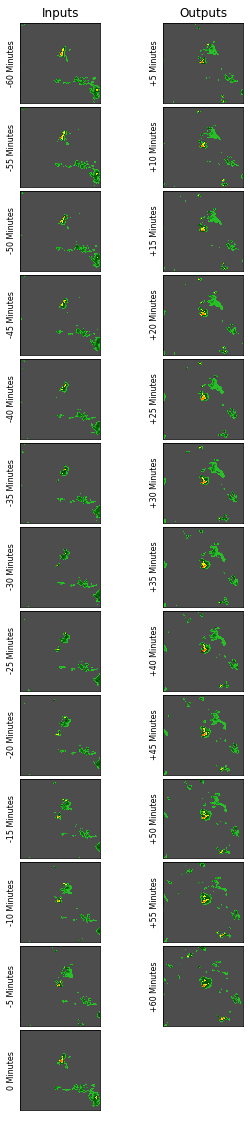

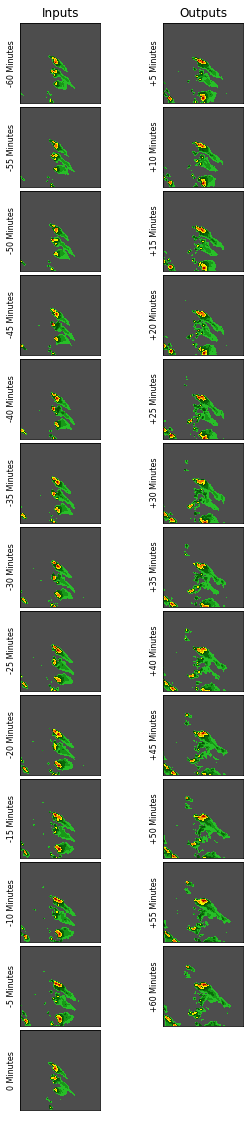

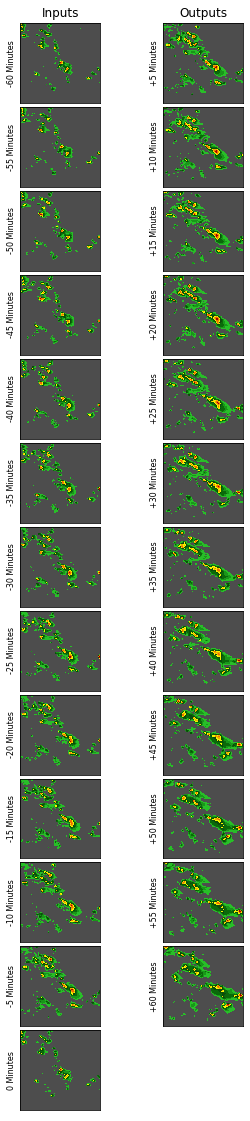

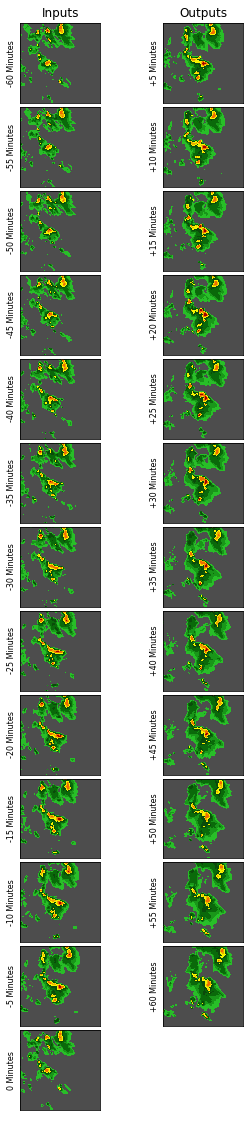

In [53]:
app = FastAPI()

app.add_middleware(
    CORSMiddleware,
    allow_origins=['*'],
    allow_credentials=True,
    allow_methods=['*'],
    allow_headers=['*'],
)


# user signup [create new user]
@app.post("/user/signup", tags=["user"])
def user_signup(user : UserSchema = Body(default=None)):
    users.append(user)
    return signJWT(user.email)

def check_user(data : UserLoginSchema):
    isValid = False
    for user in users:
        if user.email == data.email and user.password == data.password:
            isValid = True
    return isValid

# user log in
@app.post("/user/login", tags=["user"])
def user_login(user : UserLoginSchema = Body(default=None)):
    print(user)
    if check_user(user):
        return signJWT(user.email)
    else:
        return {
            "error" : "Invalid login details!"
        }


@app.get('/event')
def event_query(request: Request, idx_id: str = "", loc: str = ""):
  
  file_name = f"image_{int(datetime.now().timestamp())}.png"
  save_path = "/content/export/"
  file_path = os.path.join(save_path, file_name)
  try:
    if loc not in _locs:
      fig,ax = plt.subplots(13,2,figsize=(5,20))
      fig.delaxes(ax[12][1])
      visualize_result([gan_model],x_test,y_test,int(idx_id),ax,labels=['cGAN+MAE'],save_path=file_path)
      with open(file_path, "rb") as file:
          image_bytes: bytes = base64.b64encode(file.read())
      return {"data": image_bytes}
    else:
      return pullImages()
  except Exception as e:
    message = traceback.format_exc()
    print(message)
    return "An internal error occurred"

ngrok_tunnel = ngrok.connect(8000)
print('Public URL:', ngrok_tunnel.public_url)
nest_asyncio.apply()
uvicorn.run(app, port=8000)